In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.pyplot as plt
import os
output_dir = os.getcwd()

# Load dataset
df = pd.read_stata('../../../final_datasets/master_datasets/master_dataset_assoc_quarter_redfin.dta')

# Drop duplicates based on assoc_name_final
df_unique = df.drop_duplicates(subset='assoc_name_final', keep='first')

print(df_unique.shape)

(8206, 80)


In [2]:
# Ensure ZIP is string and clean
df['zip5_attom'] = df['zip5_attom'].astype(str).str.zfill(5)

# Create dummy indicators for story categories
df['story_1_2'] = df['num_stories_final_assoc'].between(1, 2).astype(int)
df['story_3_4'] = df['num_stories_final_assoc'].between(3, 4).astype(int)
df['story_5_9'] = df['num_stories_final_assoc'].between(5, 9).astype(int)
df['story_10p'] = (df['num_stories_final_assoc'] >= 10).astype(int)

# Aggregate to ZIP level
zip_agg = df.groupby('zip5_attom').agg({
    'story_1_2':'mean',
    'story_3_4':'mean',
    'story_5_9':'mean',
    'story_10p':'mean',
    'corp_mgmt_city_attom_assoc':'mean',
    'frac_corp_own_attom_assoc':'mean',
    'frac_npexcorp_state_attom_assoc':'mean',
    'frac_npexcorp_zip_attom_assoc':'mean'
}).reset_index()


In [3]:
zip_agg.count()

zip5_attom                         512
story_1_2                          512
story_3_4                          512
story_5_9                          512
story_10p                          512
corp_mgmt_city_attom_assoc         496
frac_corp_own_attom_assoc          496
frac_npexcorp_state_attom_assoc    496
frac_npexcorp_zip_attom_assoc      496
dtype: int64

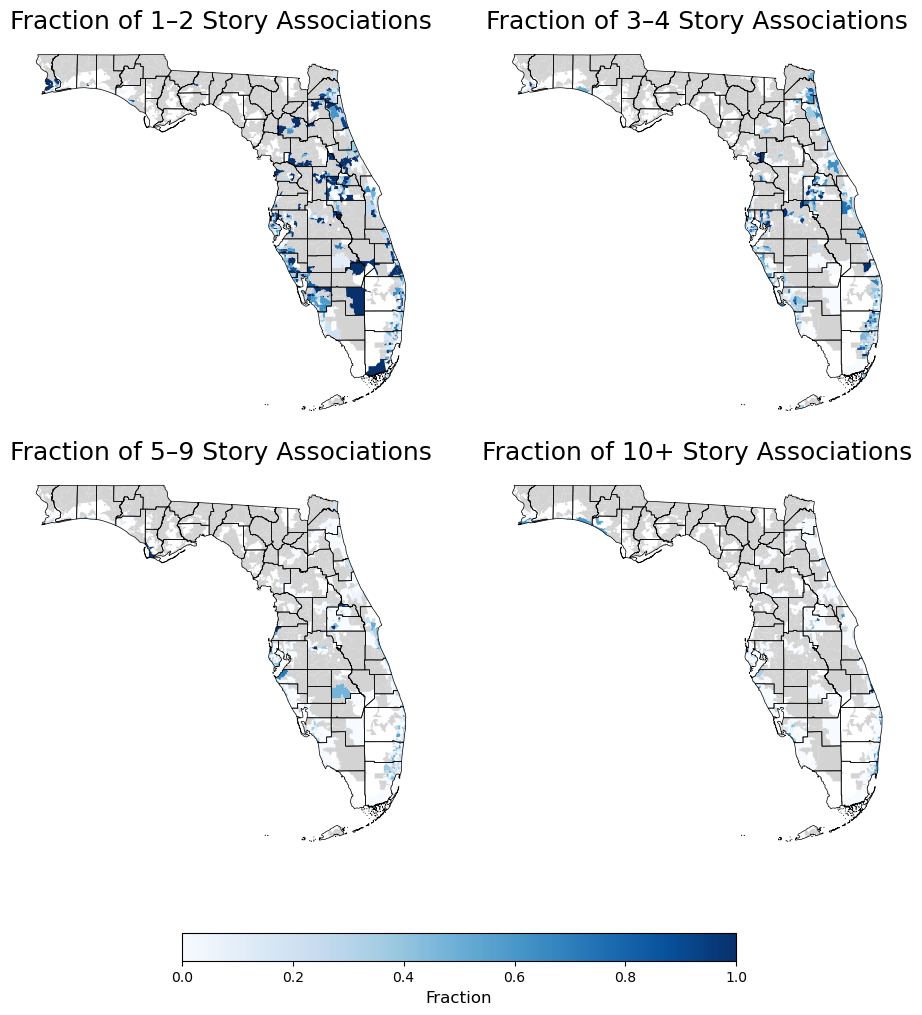

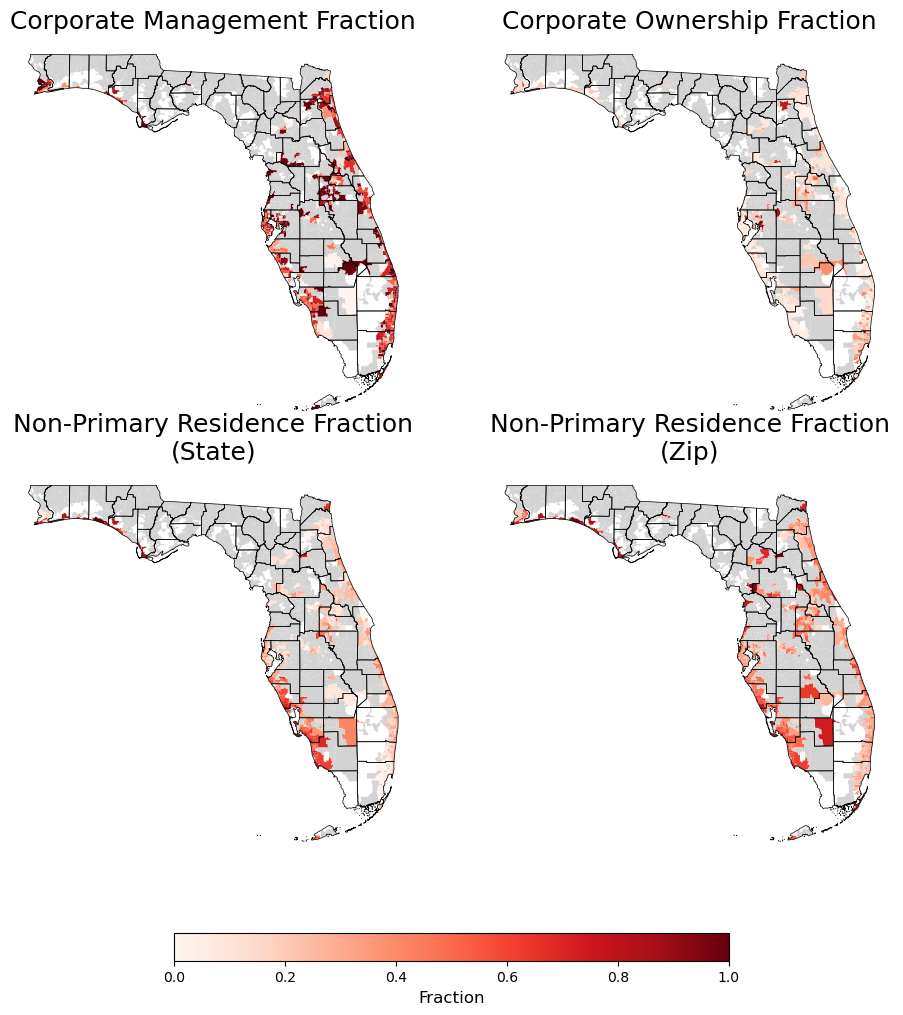

In [4]:
# ------------------------
# Load ZCTA (2018) and County boundaries
# ------------------------
zcta = gpd.read_file("cb_2018_us_zcta510_500k/cb_2018_us_zcta510_500k.shp")
counties = gpd.read_file("cb_2018_us_county_500k/cb_2018_us_county_500k.shp")

# Filter Florida
counties = counties[counties['STATEFP'] == '12']
zcta = zcta[zcta['ZCTA5CE10'].str[:2].isin(['32', '33', '34'])]

# Reproject to match
counties = counties.to_crs(zcta.crs)

# Merge ZIP-level data
zip_agg['zip5_attom'] = zip_agg['zip5_attom'].astype(str).str.zfill(5)
zcta = zcta.merge(zip_agg, left_on='ZCTA5CE10', right_on='zip5_attom', how='left')

# ------------------------
# Variables for plotting
# ------------------------
first_four = ['story_1_2', 'story_3_4', 'story_5_9', 'story_10p']
first_titles = [
    'Fraction of 1–2 Story Associations',
    'Fraction of 3–4 Story Associations',
    'Fraction of 5–9 Story Associations',
    'Fraction of 10+ Story Associations'
]

last_four = ['corp_mgmt_city_attom_assoc', 'frac_corp_own_attom_assoc', 'frac_npexcorp_state_attom_assoc', 'frac_npexcorp_zip_attom_assoc']
last_titles = [
    'Corporate Management Fraction',
    'Corporate Ownership Fraction',
    'Non-Primary Residence Fraction\n(State)',
    'Non-Primary Residence Fraction\n(Zip)'
]

# ------------------------
# Helper function for multi-panel plotting
# ------------------------
def plot_custom_grid(columns, titles, layout, filename, cmap='Blues'):
    fig, axes = plt.subplots(layout[0], layout[1], figsize=(layout[1]*6, layout[0]*6))
    axes = axes.flatten()
    fig.subplots_adjust(wspace=0.05, hspace=0.1)  # tweak as needed

    for i, col in enumerate(columns):
        ax = axes[i]
        zcta.plot(column=col,
                  cmap=cmap,
                  linewidth=0,
                  edgecolor='none',
                  ax=ax,
                  legend=False,
                  missing_kwds={'color': 'lightgrey', 'label': 'No Data'})
        counties.boundary.plot(ax=ax, color='black', linewidth=0.5)
        ax.set_title(titles[i], fontsize=18, pad=6)
        ax.axis('off')

    # Remove unused subplot if grid is bigger than number of columns
    for j in range(len(columns), len(axes)):
        axes[j].axis('off')

    # Shared colorbar below the grid
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []
    cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.03, pad=0.08)
    cbar.set_label('Fraction', fontsize=12)


    #plt.tight_layout()
    #plt.savefig(filename, dpi=300, bbox_inches='tight')
    #plt.show()

# ------------------------
# Create the two figures
# ------------------------
# Stories: 2x2 grid
fig1 = plot_custom_grid(first_four, first_titles, layout=(2, 2), filename='florida_building_heights.png', cmap='Blues')
plt.savefig(os.path.join(output_dir, 'florida_building_heights.png'), dpi=300, bbox_inches='tight')
plt.show()

# Ownership: 2 rows, 2 columns (last cell empty)
fig2 = plot_custom_grid(last_four, last_titles, layout=(2, 2), filename='florida_corporate_ownership.png', cmap='Reds')
plt.savefig(os.path.join(output_dir, 'florida_corporate_ownership.png'), dpi=300, bbox_inches='tight')
plt.show()
